# 一、基于词袋模型（SVM）

## 导入相关的库

In [10]:
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import brown
from nltk import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk import FreqDist
from gensim.models.word2vec import Word2Vec
import joblib
import jieba
from nltk.corpus import stopwords
#词云图必备库
import wordcloud
from wordcloud import WordCloud
import matplotlib as plt
from matplotlib import pyplot as plt
import imageio

D:\Software\python\Lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 导入爬取的数据

In [11]:
comment_positive = pd.read_csv('D:/jd_good_comment.csv',encoding="gb18030")
comment_positive["y"] = 1
comment_positive.drop(["颜色",'型号'],axis = 1)
# df0 = comment_positive.append()

,评价,y
0,之前看过草枕，京东购书还是不错的，特别是有活动的时候，99块10本，选到自己喜欢的书籍，可以...,1
1,京东发货速度还是没个说的。这次活动很给力，一下选了40多本，大人小孩都够看一段时间了。书柜也...,1
2,京东品类丰富，物品保真，包装完善，价格公道，优惠活动多多。\n产品品质有保证，款式新颖，自营...,1
3,首先，发货算是挺及时。\n其次，快递非常快，楼下有快递站，拿也挺方便的。包装也很好，没损坏。...,1
4,书很不错，字体清晰大小合适，排班整洁易于阅读。很好读起来很畅快。书本身精彩有趣，笔触优美，很...,1
...,...,...
544,一直在京东买书，价格还算可以，所以基本没带孩子如果书店，这个比较失败。家里有小宝宝，真心走不...,1
545,希望宝宝可以喜欢这些书 养成看书的好习惯 书的质量非常好 值得购买,1
546,书的质量很好，是正版，快递一天就到了。黑泽明的电影看过了，看看书,1
547,京东物流很快，购物方便，活动时间买书很划算，书也不错，好评！,1


In [12]:
comment_negative = pd.read_csv('D:/jd_bad_comment.csv',encoding="gb18030")
comment_negative = comment_negative.drop_duplicates()
comment_negative['y'] = 0
comment_negative
comment_negative.drop(columns = ["颜色","型号"],axis = 1)

,评价,y
0,书都快出来了！！！,0
1,一次买了十本书，就这本书质量最差，无数的空白页，一看就是盗版，决不要在他家买书了！！！,0
2,真的不敢恭维，你告诉我这是保证正版图书？纸张薄的要命，内容还有串了的，如果不是过了你们自己所...,0
3,说实话，这个99十本书有点坑。。。果然是便宜没好货，看着图片很不错，实际书都是那种劣质纸张做...,0
4,一言难尽不知道你懂不懂，这盗版书不能再盗版了，99十本书有点坑。看着图片不错，实际书都是那种...,0
...,...,...
247,为什么是删减版,0
248,一点也不好,0
249,差评，书写到一半就没了，连个句号都没有,0
250,是短片小说，不好看，欣赏不来。,0


将好评和差评数据合并到一个表格中

In [13]:
comment_sum = comment_positive.append(comment_negative,ignore_index=True)
comment_sum["0"] = " "
comment_sum

,评价,颜色,型号,y,0
0,之前看过草枕，京东购书还是不错的，特别是有活动的时候，99块10本，选到自己喜欢的书籍，可以...,我是猫,NaN,1,
1,京东发货速度还是没个说的。这次活动很给力，一下选了40多本，大人小孩都够看一段时间了。书柜也...,了不起的盖茨比,NaN,1,
2,京东品类丰富，物品保真，包装完善，价格公道，优惠活动多多。\n产品品质有保证，款式新颖，自营...,鲁滨孙漂流记,NaN,1,
3,首先，发货算是挺及时。\n其次，快递非常快，楼下有快递站，拿也挺方便的。包装也很好，没损坏。...,纳兰词,NaN,1,
4,书很不错，字体清晰大小合适，排班整洁易于阅读。很好读起来很畅快。书本身精彩有趣，笔触优美，很...,了不起的盖茨比,NaN,1,
...,...,...,...,...,...
742,为什么是删减版,双城记,NaN,0,
743,一点也不好,居里夫人自传,NaN,0,
744,差评，书写到一半就没了，连个句号都没有,居里夫人自传,NaN,0,
745,是短片小说，不好看，欣赏不来。,罗生门,NaN,0,


使用jieba.lcut()进行分词处理，由于很多语气词也算情感词，因此这里不导入停用词

In [14]:
cut_word = lambda x :" ".join(jieba.lcut(x))
cut_word

<function __main__.<lambda>(x)>

将分词结果导入到表表格中

In [15]:
comment_sum["clean_text"] = comment_sum['评价'].apply(cut_word)
comment_sum.head(20)

Building prefix dict from the default dictionary ...
Loading model from cache D:\temps\jieba.cache
Loading model cost 0.623 seconds.
Prefix dict has been built successfully.


,评价,颜色,型号,y,0,clean_text
0,之前看过草枕，京东购书还是不错的，特别是有活动的时候，99块10本，选到自己喜欢的书籍，可以...,我是猫,NaN,1,,之前 看过 草枕 ， 京东 购书 还是 不错 的 ， 特别 是 有 活动 的 时候 ， 99...
1,京东发货速度还是没个说的。这次活动很给力，一下选了40多本，大人小孩都够看一段时间了。书柜也...,了不起的盖茨比,NaN,1,,京东 发货 速度 还是 没个 说 的 。 这次 活动 很 给 力 ， 一下 选 了 40 多...
2,京东品类丰富，物品保真，包装完善，价格公道，优惠活动多多。\n产品品质有保证，款式新颖，自营...,鲁滨孙漂流记,NaN,1,,京东 品类 丰富 ， 物品 保真 ， 包装 完善 ， 价格公道 ， 优惠活动 多多 。 \n...
3,首先，发货算是挺及时。\n其次，快递非常快，楼下有快递站，拿也挺方便的。包装也很好，没损坏。...,纳兰词,NaN,1,,首先 ， 发货 算是 挺 及时 。 \n 其次 ， 快递 非常 快 ， 楼下 有 快递 站 ...
4,书很不错，字体清晰大小合适，排班整洁易于阅读。很好读起来很畅快。书本身精彩有趣，笔触优美，很...,了不起的盖茨比,NaN,1,,书 很 不错 ， 字体 清晰 大小 合适 ， 排班 整洁 易于 阅读 。 很 好 读 起来 ...
5,京东这个活动每年都参加，99买十本，而且包装特别好，送货特别快，书籍种类特别多，通过大家买的...,局外人,NaN,1,,京东 这个 活动 每年 都 参加 ， 99 买 十本 ， 而且 包装 特别 好 ， 送货 特...
6,京东发货速度还是没个说的。这次活动很给力，一下选了40多本，大人小孩都够看一段时间了。书柜也...,纳兰词,NaN,1,,京东 发货 速度 还是 没个 说 的 。 这次 活动 很 给 力 ， 一下 选 了 40 多...
7,孩子特别喜欢这本书，说非常喜欢，问了我很多问题，书是正版，印刷很好，无异味，值得购买,一只黑猩猩的宇宙史,NaN,1,,孩子 特别 喜欢 这 本书 ， 说 非常 喜欢 ， 问 了 我 很多 问题 ， 书 是 正版...
8,买东西买书上京东，京东一下一时爽，一直京东一直爽。给力\n啊！非常好的购物体验，又快，又好，...,罗生门,NaN,1,,买 东西 买 书上 京东 ， 京东 一下 一时 爽 ， 一直 京东 一 直爽 。 给力 \n...
9,一年一度的京东618活动又来了，把购物车里面积攒的书籍，趁着活动都给清仓了，拉上同事买了一小...,局外人,NaN,1,,一年一度 的 京东 618 活动 又 来 了 ， 把 购物车 里面 积攒 的 书籍 ， 趁着...


导入feature_extraction库，将分词结果转化为向量矩阵

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(min_df = 1)

wordmtx = countvec.fit_transform(comment_sum.clean_text)
wordmtx

<747x2891 sparse matrix of type '<class 'numpy.int64'>'
	with 12969 stored elements in Compressed Sparse Row format>

生成训练集和测试集，按照30%来抽取测试集，生成了2891个矩阵

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(
    wordmtx,
    comment_sum.y,test_size=0.3
)
x_train[0]

<1x2891 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

使用SVM进行建模，模型评分为0.97，准确率较高

In [18]:
from sklearn.svm import SVC
clf = SVC(kernel = 'rbf',verbose = True)
clf.fit(x_train,y_train)
clf.score(x_train,y_train)

[LibSVM]

0.9885057471264368

对模型效果进行评估，可以看出在预测上，正向结果和负向结果的精准度有较大的差别，说明该模型并不平衡，具有改进的空间

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test,clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        64
           1       0.92      0.95      0.94       161

    accuracy                           0.91       225
   macro avg       0.89      0.87      0.88       225
weighted avg       0.91      0.91      0.91       225



将数据集转成用于训练的向量

In [20]:
clf.predict(countvec.transform([comment_sum.clean_text[1]]))[0]

1

在comment栏输入相关评论，对模型进行预测

In [21]:
import jieba
def m_pred(string,countvec,model):
    words = " ".join(jieba.lcut(string))
    words_vecs = countvec.transform([words])
    
    result = model.predict(words_vecs)
    
    if int(result[0]) == 1:
        print(string,": 正向")
    else:
        print(string,": 负向")

comment = "说实话，这个99十本书有点坑。。。果然是便宜没好货，看着图片很不错，实际书都是那种劣质纸张做..."
m_pred(comment,countvec,clf)

说实话，这个99十本书有点坑。。。果然是便宜没好货，看着图片很不错，实际书都是那种劣质纸张做... : 负向


In [22]:
comment2 = "首先，发货算是挺及时。\n其次，快递非常快，楼下有快递站，拿也挺方便的。包装也很好，没损坏。"
m_pred(comment2,countvec,clf)

首先，发货算是挺及时。
其次，快递非常快，楼下有快递站，拿也挺方便的。包装也很好，没损坏。 : 正向


# 二、基于word2vec（分布式表达）的分析

导入数据

In [23]:
dfpos = pd.read_csv('D:/jd_good_comment_max.csv',encoding="gb18030")
dfpos["y"] = 1
dfpos.drop(["颜色",'型号'],axis = 1)
dfneg = pd.read_csv('D:/jd_bad_comment_max.csv',encoding="gb18030")
dfneg = comment_negative.drop_duplicates()
dfneg['y'] = 0
dfneg.drop(columns = ["颜色","型号"],axis = 1)
df_sum = dfpos.append(dfneg,ignore_index=True)
df_sum

,Unnamed: 0,评价,颜色,型号,y
0,1.0,之前看过草枕，京东购书还是不错的，特别是有活动的时候，99块10本，选到自己喜欢的书籍，可以...,我是猫,NaN,1
1,2.0,京东发货速度还是没个说的。这次活动很给力，一下选了40多本，大人小孩都够看一段时间了。书柜也...,了不起的盖茨比,NaN,1
2,3.0,京东品类丰富，物品保真，包装完善，价格公道，优惠活动多多。\n产品品质有保证，款式新颖，自营...,鲁滨孙漂流记,NaN,1
3,4.0,首先，发货算是挺及时。\n其次，快递非常快，楼下有快递站，拿也挺方便的。包装也很好，没损坏。...,纳兰词,NaN,1
4,5.0,书很不错，字体清晰大小合适，排班整洁易于阅读。很好读起来很畅快。书本身精彩有趣，笔触优美，很...,了不起的盖茨比,NaN,1
...,...,...,...,...,...
1468,NaN,为什么是删减版,双城记,NaN,0
1469,NaN,一点也不好,居里夫人自传,NaN,0
1470,NaN,差评，书写到一半就没了，连个句号都没有,居里夫人自传,NaN,0
1471,NaN,是短片小说，不好看，欣赏不来。,罗生门,NaN,0


分词操作

In [24]:
df_sum["cut"] = df_sum['评价'].apply(jieba.lcut)
df_sum.drop(['颜色','型号'],axis =1)

,Unnamed: 0,评价,y,cut
0,1.0,之前看过草枕，京东购书还是不错的，特别是有活动的时候，99块10本，选到自己喜欢的书籍，可以...,1,"[之前, 看过, 草枕, ，, 京东, 购书, 还是, 不错, 的, ，, 特别, 是, 有..."
1,2.0,京东发货速度还是没个说的。这次活动很给力，一下选了40多本，大人小孩都够看一段时间了。书柜也...,1,"[京东, 发货, 速度, 还是, 没个, 说, 的, 。, 这次, 活动, 很, 给, 力,..."
2,3.0,京东品类丰富，物品保真，包装完善，价格公道，优惠活动多多。\n产品品质有保证，款式新颖，自营...,1,"[京东, 品类, 丰富, ，, 物品, 保真, ，, 包装, 完善, ，, 价格公道, ，,..."
3,4.0,首先，发货算是挺及时。\n其次，快递非常快，楼下有快递站，拿也挺方便的。包装也很好，没损坏。...,1,"[首先, ，, 发货, 算是, 挺, 及时, 。, \n, 其次, ，, 快递, 非常, 快..."
4,5.0,书很不错，字体清晰大小合适，排班整洁易于阅读。很好读起来很畅快。书本身精彩有趣，笔触优美，很...,1,"[书, 很, 不错, ，, 字体, 清晰, 大小, 合适, ，, 排班, 整洁, 易于, 阅..."
...,...,...,...,...
1468,NaN,为什么是删减版,0,"[为什么, 是, 删减, 版]"
1469,NaN,一点也不好,0,"[一点, 也, 不好]"
1470,NaN,差评，书写到一半就没了，连个句号都没有,0,"[差评, ，, 书写, 到, 一半, 就, 没, 了, ，, 连, 个, 句号, 都, 没有]"
1471,NaN,是短片小说，不好看，欣赏不来。,0,"[是, 短片, 小说, ，, 不, 好看, ，, 欣赏, 不, 来, 。]"


以7:3的格式生成训练集和测试集

In [25]:
from sklearn.model_selection import train_test_split
x_xunlian,x_ceshi,y_xunlian,y_ceshi = train_test_split(
    df_sum.cut,df_sum.y,test_size=0.3
)
x_xunlian[0:100]

1243    [特别, 好, 的, 书, ，, 简直, 是, 物美价廉, 。, 可以, 学习, 和, 了解...
212     [这么, 多书, ，, 可, 算是, 收到, 了, ，, 卖家, 发货, 很快, ，, 物流...
1282    [这本, 城堡, 可以, 说, 非常, 差, 了, ，, 你们, 看看, 排班, 就, 知道...
1306                           [此, 用户, 未, 及时, 填写, 评价, 内容]
741     [京东, 图书, 双十, 一, 活动, ，, 价格, 相当, 用心, 了, ，, 各种, 叠...
                              ...                        
1127              [包装, 很, 精美, ，, 物流, 也, 很快, ！, 急切, 拜读, ！]
732            [很, 不错, 的, 书, ，, 小朋友, 很, 喜欢, ，, 配送, 速度, 快]
1235    [京东, 自营, 的, 图书, ，, 价格, 很, 美丽, 。, 买, 了, 好多, 呢, ...
1101    [反, 乌托邦, 三部曲, 买全, 了, ，, 京东, 打折, 优惠, 力度, 很大, ，, 赞]
340                                                  [评价]
Name: cut, Length: 100, dtype: object

导入gensim包，设置w2v模型

In [26]:
from gensim.models.word2vec import Word2Vec

n_dim = 50
w2vmodel = Word2Vec(vector_size=n_dim ,min_count=1)
w2vmodel.build_vocab(x_xunlian)

### 在评论训练集上建模

In [27]:
%time w2vmodel.train( x_xunlian, \
    total_examples=w2vmodel.corpus_count,epochs=1)

Wall time: 24.5 ms


(25963, 39027)

### 判断情感词向量之间的相似度

In [28]:
w2vmodel.wv.most_similar("好")

[('的', 0.9979045987129211),
 ('，', 0.9978995323181152),
 ('。', 0.9977269768714905),
 ('！', 0.9975091218948364),
 ('京东', 0.9973722100257874),
 ('了', 0.9973372220993042),
 ('是', 0.9972596764564514),
 ('很', 0.9971070289611816),
 ('都', 0.9970918297767639),
 ('也', 0.9968633651733398)]

In [29]:
w2vmodel.wv.most_similar("可以")

[('的', 0.9971006512641907),
 ('，', 0.9970983862876892),
 ('都', 0.9969091415405273),
 ('了', 0.9968224763870239),
 ('京东', 0.9966505169868469),
 ('很', 0.9965073466300964),
 ('！', 0.9964559674263),
 ('也', 0.9963604807853699),
 ('是', 0.9963380098342896),
 ('活动', 0.9962599277496338)]

### 生成整句向量用于情感词预测

In [30]:
a = pd.DataFrame([w2vmodel.wv[w] for w in df_sum.cut[0] if w in w2vmodel.wv])
a

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.002719,-0.011818,0.016423,0.005245,-0.009219,0.003074,0.013577,0.023160,0.001390,-0.025841,...,0.009896,0.015136,-0.004366,0.012651,0.016593,0.010369,-0.016997,0.007290,0.014640,0.021764
1,-0.008406,-0.011891,0.017645,0.002486,-0.025997,-0.025640,0.050415,0.044956,-0.042756,-0.010869,...,0.000749,-0.007871,-0.021541,0.009767,0.039747,0.012628,0.004076,-0.035864,0.010925,0.021204
2,-0.002322,0.004921,-0.014018,0.000818,-0.020432,0.011299,0.004815,0.020172,0.006132,0.000816,...,-0.018945,0.005738,0.004288,0.019892,-0.006822,-0.019526,-0.019676,0.000466,0.013602,0.018096
3,0.174623,-0.023553,0.217905,0.183120,-0.237240,-0.565647,0.818398,1.274845,-1.016531,-0.445074,...,0.292316,0.049560,-0.088239,0.313914,0.980936,-0.052374,-0.130661,-0.504107,0.373079,0.668292
4,0.083741,-0.011110,0.068336,0.050456,-0.104924,-0.233803,0.347471,0.553488,-0.417727,-0.194440,...,0.119342,0.013017,-0.031104,0.131230,0.436906,-0.022533,-0.038539,-0.237955,0.149920,0.264168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.006135,-0.018129,-0.013512,0.004722,-0.003894,-0.011442,0.032502,0.034514,-0.029510,-0.016291,...,-0.006287,0.012422,-0.015539,-0.000584,0.013338,-0.005418,0.004667,0.005623,-0.012916,-0.006834
79,0.011647,-0.012592,0.000541,-0.004369,-0.009547,-0.056180,0.056668,0.095647,-0.071976,-0.025581,...,0.018952,0.014057,-0.023691,0.027703,0.092709,-0.019264,-0.004662,-0.052450,0.045687,0.055846
80,0.012585,-0.009308,0.010816,0.015669,-0.035260,-0.080370,0.101397,0.155294,-0.128561,-0.062186,...,0.043932,0.019446,-0.001843,0.061448,0.152789,0.002338,-0.028741,-0.057953,0.031271,0.079007
81,0.000819,-0.018310,-0.004395,0.018492,-0.019286,-0.017154,0.037234,0.093925,-0.047382,-0.022748,...,0.012297,0.000779,0.004801,0.024003,0.066294,0.014062,-0.024765,-0.046814,0.009905,0.028072


### 生成建模所用的矩阵

In [31]:
def m_avgvec(word , w2vmodel):
    return a.agg('mean')

In [32]:
%time train_vecs = pd.DataFrame([m_avgvec(s,w2vmodel) for s in x_xunlian])
train_vecs.head()

Wall time: 472 ms


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.061072,-0.009056,0.0747,0.060978,-0.080048,-0.193779,0.285566,0.442638,-0.356194,-0.153846,...,0.106169,0.015279,-0.027914,0.11165,0.344924,-0.016161,-0.043191,-0.182148,0.126877,0.229932
1,0.061072,-0.009056,0.0747,0.060978,-0.080048,-0.193779,0.285566,0.442638,-0.356194,-0.153846,...,0.106169,0.015279,-0.027914,0.11165,0.344924,-0.016161,-0.043191,-0.182148,0.126877,0.229932
2,0.061072,-0.009056,0.0747,0.060978,-0.080048,-0.193779,0.285566,0.442638,-0.356194,-0.153846,...,0.106169,0.015279,-0.027914,0.11165,0.344924,-0.016161,-0.043191,-0.182148,0.126877,0.229932
3,0.061072,-0.009056,0.0747,0.060978,-0.080048,-0.193779,0.285566,0.442638,-0.356194,-0.153846,...,0.106169,0.015279,-0.027914,0.11165,0.344924,-0.016161,-0.043191,-0.182148,0.126877,0.229932
4,0.061072,-0.009056,0.0747,0.060978,-0.080048,-0.193779,0.285566,0.442638,-0.356194,-0.153846,...,0.106169,0.015279,-0.027914,0.11165,0.344924,-0.016161,-0.043191,-0.182148,0.126877,0.229932


### 对情感分析模型进行优化拟合

In [33]:
from sklearn.svm import SVC
clf2 = SVC(kernel = "rbf",verbose=True)
clf2.fit(train_vecs,y_xunlian)
clf2.score(train_vecs,y_xunlian)

[LibSVM]

0.8651794374393792

### 使用classification_report查看拟合效果

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_xunlian,clf2.predict(train_vecs)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       139
           1       0.87      1.00      0.93       892

    accuracy                           0.87      1031
   macro avg       0.43      0.50      0.46      1031
weighted avg       0.75      0.87      0.80      1031



D:\Software\python\Lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Software\python\Lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Software\python\Lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 保存模型，方便日后调用

In [35]:
import joblib
joblib.dump(clf2,"评论情感分析模型")

['评论情感分析模型']

### 对模型进行二次预测

In [37]:
import jieba

def w_pred(string,model):
    words = jieba.lcut(string)
    words_vecs = pd.DataFrame(m_avgvec(words,w2vmodel)).T
    
    result = model.predict(words_vecs)
    
    if int(result[0]) == 1:
        print(string,": 正向")
    else:
        print(string,": 负向")

comment1 = "假书，从内容到外表，跟原版太差了，退货"
comment2 = "京东品类丰富，物品保真，包装完善，价格公道，优惠活动多多"

print(w_pred(comment1,clf2)
      ,w_pred(comment2,clf2))

假书，从内容到外表，跟原版太差了，退货 : 正向
京东品类丰富，物品保真，包装完善，价格公道，优惠活动多多 : 正向
None None


### word2vec小结
- word2vec模型要想起作用，需要大量的语料文本分析作为基础，来进行建模。本次爬取的负向评论样本量不足，因此对于负向评论模型预测的准确率很低

# 三、评论词云图展现

In [38]:
#首先使用jieba进行分词处理
cut_words = jieba.lcut(str(comment_negative['评价'].values),cut_all = False)
cut_words[:10]

['[', "'", '书', '都', '快', '出来', '了', '！', '！', '！']

In [39]:
#导入停用词
with open('D:/系统默认/桌面/停用词.txt',encoding="utf-8") as f:
    stop_word = f.read()

new_comment = [] #新定义一个空列表
for word in cut_words:
    if word not in stop_word:
        new_comment.append(word) #将不在停用词里的评论导入到空列表中
new_comment[:20]

['书',
 '买',
 '本书',
 '本书',
 '质量',
 '最差',
 '无数',
 '空白页',
 '一看',
 '盗版',
 '他家',
 '买书',
 '真的',
 '不敢恭维',
 '告诉',
 '保证',
 '正版',
 '图书',
 '纸张',
 '薄']

### 使用FreqDist和most_common_words找出最常出现的评论

In [40]:
freq_list = FreqDist(new_comment)
most_common_words = freq_list.most_common(5)
most_common_words

[('买', 44), ('书', 26), ('标价', 22), ('虚高', 22), ('薄', 20)]

### 绘制词云图

In [ ]:
from PIL import Image
import numpy as np
import wordcloud
from wordcloud import WordCloud
 

In [72]:
JD = plt.imread(r'D:\系统默认\桌面\京东.jpg')

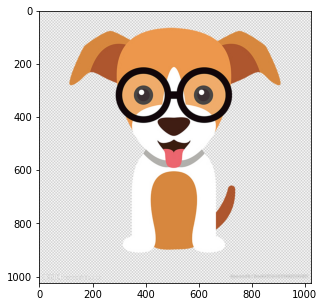

In [89]:
plt.figure(figsize=(5,5))
plt.imshow(JD)

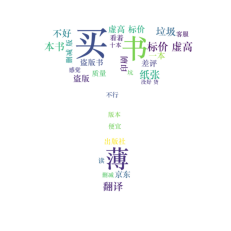

In [87]:
mask = JD
w = WordCloud(
    font_path='C:\Windows\Fonts\STZHONGS.TTF',
    background_color="white",
    height=1000,
    width =2000,
    max_words = 30,
    max_font_size= 300,
    mask=mask
)

plt.imshow(w.generate(" ".join(new_comment)))

plt.axis("off")
plt.show()
w_image.to_file("京东图书评论3.png")

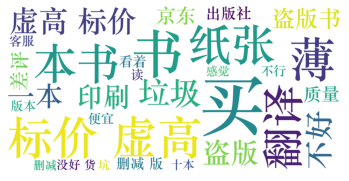

In [95]:
w = WordCloud(
    font_path='C:\Windows\Fonts\STZHONGS.TTF',
    background_color="white",
    height=1000,
    width =2000,
    max_words = 30,
    max_font_size= 400,
    #mask=mask
)

plt.imshow(w.generate(" ".join(new_comment)))

plt.axis("off")
plt.show()
w_image.to_file("京东图书评论3.png")